In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df_VCB = pd.read_csv('../2. data_vn_20230228/stock-historical-data/VCB-VNINDEX-History.csv')
df_series = df_VCB[-365:].reset_index()['Close']
df = df_series.to_frame()
df

,Close
0,75949.0
1,76104.0
2,75175.0
3,75949.0
4,75252.0
...,...
360,93000.0
361,93300.0
362,93500.0
363,92800.0


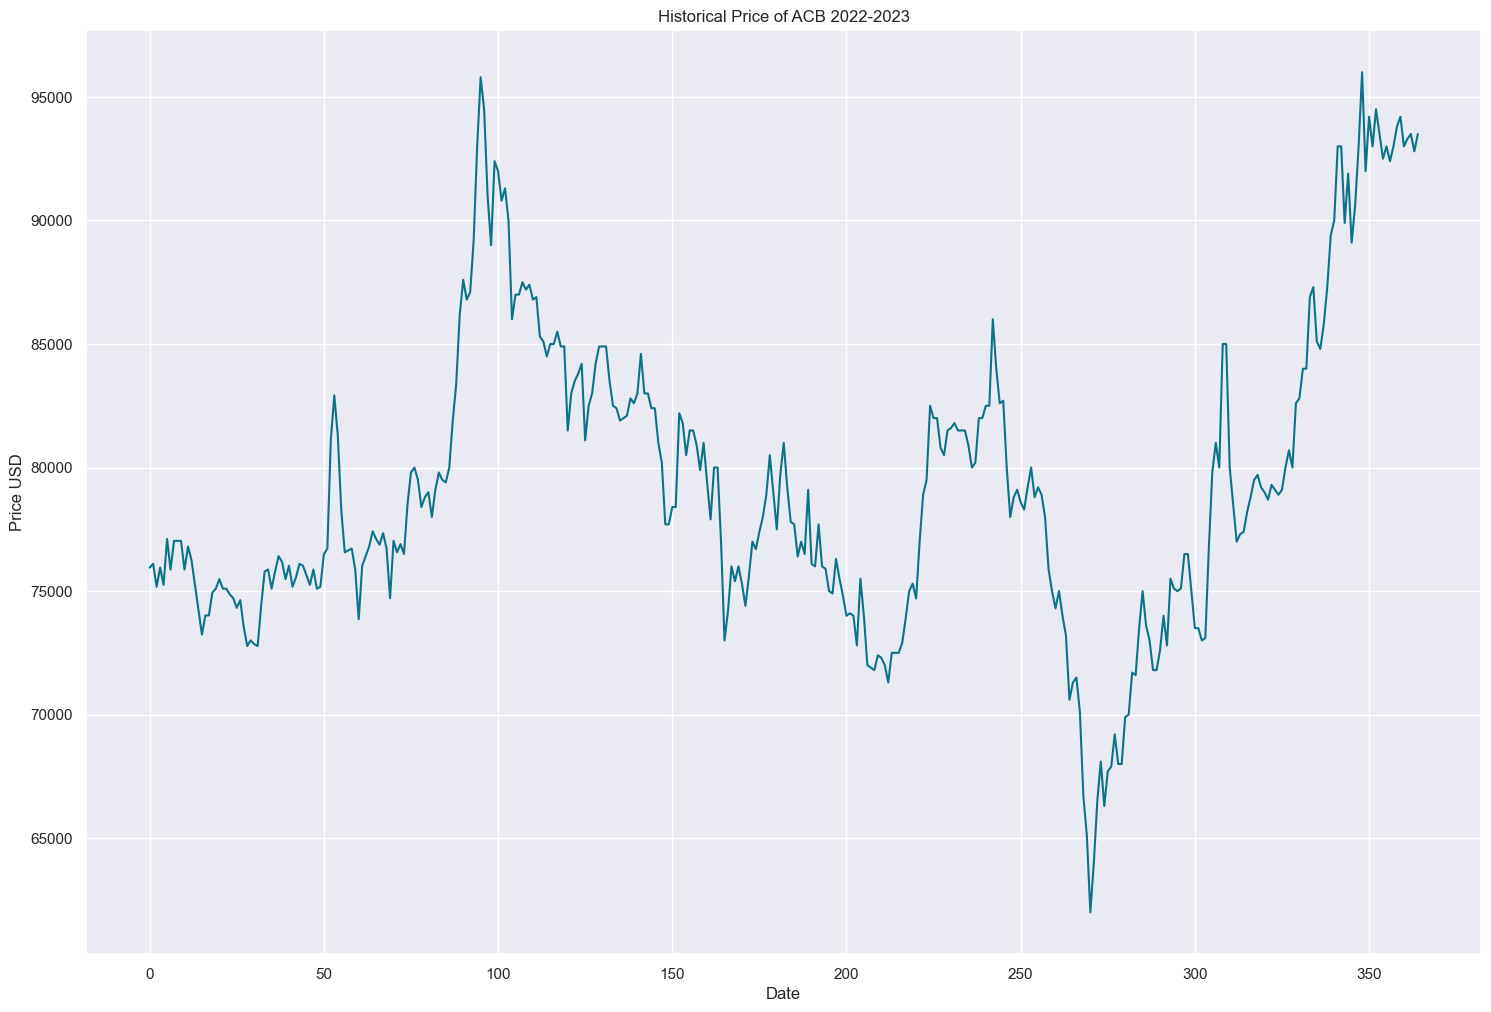

In [3]:
plt.rcParams['figure.figsize'] = (18, 12)

def price(x):
    """
    format the coords message box
    :param x: data to be formatted
    :return: formatted data
    """
    return '$%1.2f' % x

fig, ax = plt.subplots()
ax.plot(df.index, df['Close'], '#0A7388')
ax.format_ydata = price
# Add labels
plt.ylabel("Price USD")
plt.xlabel("Date")
plt.title("Historical Price of ACB 2022-2023")

plt.show()

In [4]:
# ref: https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/agent/3.signal-rolling-agent.ipynb 

def buy_stock(real_movement,delay,initial_state,initial_money,max_buy,max_sell):
    """
    real_movement: actual movement in the real world
    delay: how much days you want to delay to change the trading decision
    initial_state: 1 is buy, 0 is sell
    initial_money: ignore what kind of currency
    max_buy: max quantity for share to buy
    max_sell: max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print('day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i]))
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print('day %d: buy %d unit at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money))
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(0, initial_money, current_inventory)

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(i, initial_money, current_inventory)
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = ((real_movement[i] - real_movement[states_buy[-1]])/ real_movement[states_buy[-1]]) * 100
                    except:
                        invest = 0
                    print('day %d, sell %d unit at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money))
                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 3, initial_money = 100000, 
                                                         max_buy = 1, max_sell = 1)


day 0: buy 1 unit at price 75949.000000, total balance 24051.000000
day 7, sell 1 unit at price 77033.000000, investment 1.427274 %, total balance 101084.000000,
day 14: buy 1 unit at price 74246.000000, total balance 26838.000000
day 20, sell 1 unit at price 75485.000000, investment 1.668777 %, total balance 102323.000000,
day 25: buy 1 unit at price 74323.000000, total balance 28000.000000
day 33, sell 1 unit at price 75794.000000, investment 1.979199 %, total balance 103794.000000,
day 41: buy 1 unit at price 75175.000000, total balance 28619.000000
day 49, sell 1 unit at price 75175.000000, investment 0.000000 %, total balance 103794.000000,
day 59: buy 1 unit at price 75872.000000, total balance 27922.000000
day 64, sell 1 unit at price 77420.000000, investment 2.040278 %, total balance 105342.000000,
day 69: buy 1 unit at price 74710.000000, total balance 30632.000000
day 75, sell 1 unit at price 79800.000000, investment 6.813010 %, total balance 110432.000000,
day 84: buy 1 unit

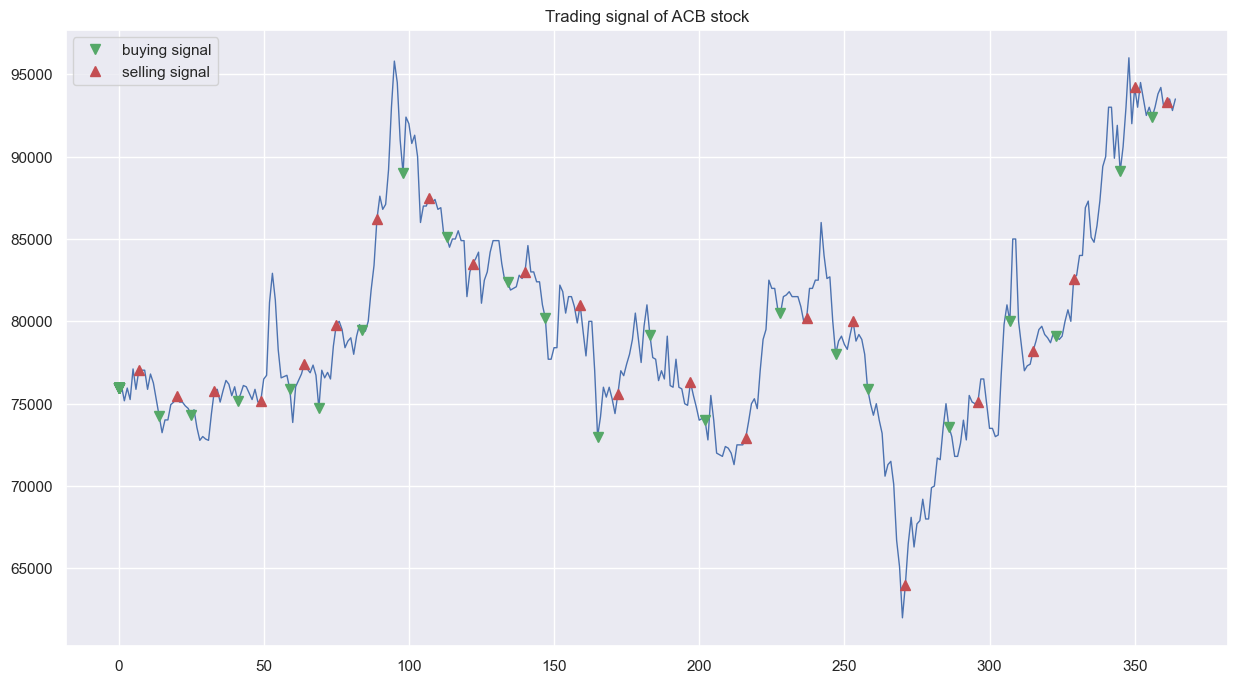

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,8))
plt.plot(close, color='b', lw=1)
plt.plot(close, 'v', markersize=7, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, '^', markersize=7, color='r', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.title('Trading signal of ACB stock')
plt.legend()
plt.savefig('Trading Point.png')
plt.show()

In [41]:
df_VCB = pd.read_csv('../2. data_vn_20230228/stock-historical-data/VCB-VNINDEX-History.csv')
df_series = df_ACB[-30:].reset_index()['Close']
df = df_series.to_frame()
states_buy, states_sell, total_gains1, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 10, initial_money = 100000, 
                                                         max_buy = 1, max_sell = 1)

day 0: buy 1 unit at price 24200.000000, total balance 75800.000000
day 21, sell 1 unit at price 24800.000000, investment 2.479339 %, total balance 100600.000000,


In [42]:
df_ACB = pd.read_csv('../2. data_vn_20230228/stock-historical-data/ACB-VNINDEX-History.csv')
df_series = df_ACB[-30:].reset_index()['Close']
df = df_series.to_frame()
states_buy, states_sell, total_gains2, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 10, initial_money = 100000, 
                                                         max_buy = 1, max_sell = 1)

day 0: buy 1 unit at price 24200.000000, total balance 75800.000000
day 21, sell 1 unit at price 24800.000000, investment 2.479339 %, total balance 100600.000000,


In [43]:
df_TPB = pd.read_csv('../2. data_vn_20230228/stock-historical-data/TPB-VNINDEX-History.csv')
df_series = df_TPB[-30:].reset_index()['Close']
df = df_series.to_frame()
states_buy, states_sell, total_gains3, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 10, initial_money = 100000, 
                                                         max_buy = 1, max_sell = 1)

day 0: buy 1 unit at price 20232.000000, total balance 79768.000000
day 19, sell 1 unit at price 21178.000000, investment 4.675761 %, total balance 100946.000000,


In [44]:
df_VPB = pd.read_csv('../2. data_vn_20230228/stock-historical-data/VPB-VNINDEX-History.csv')
df_series = df_VPB[-30:].reset_index()['Close']
df = df_series.to_frame()
states_buy, states_sell, total_gains4, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 10, initial_money = 100000, 
                                                         max_buy = 1, max_sell = 1)

day 0: buy 1 unit at price 18450.000000, total balance 81550.000000
day 21, sell 1 unit at price 17500.000000, investment -5.149051 %, total balance 99050.000000,


In [45]:
df_HDB = pd.read_csv('../2. data_vn_20230228/stock-historical-data/HDB-VNINDEX-History.csv')
df_series = df_HDB[-30:].reset_index()['Close']
df = df_series.to_frame()
states_buy, states_sell, total_gains5, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 10, initial_money = 100000, 
                                                         max_buy = 1, max_sell = 1)

day 0: buy 1 unit at price 16700.000000, total balance 83300.000000
day 15, sell 1 unit at price 18300.000000, investment 9.580838 %, total balance 101600.000000,


In [49]:
(total_gains1 + total_gains2 + total_gains3 + total_gains4 + total_gains5 + 500000)/500000 * 100

100.5592